# Oferta e Demanda

In [52]:
import pandas as pd
import numpy as np
import json
import importlib, sys, os, requests
from datetime import date, datetime
from bs4 import BeautifulSoup

from pathlib import Path
sys.path.append(str(Path(os.path.abspath('')).parents[0]))

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import yfinance as yf
import investpy

import support_library as sl

_ = [importlib.reload(sys.modules[m]) for m in list(sys.modules) if 'support_library' in m]

In [53]:
DATE_FORMAT = '%Y-%m-%d'
MIN_DATE    = "2010-01-01"
TODAY       = date.today()
TODAY_STR   = date.today().strftime(DATE_FORMAT)
REF_MES     = 12 
THIS_YEAR   = "2022-01-01"

DATASET     = r'../dataset/'

TODAY

datetime.date(2022, 4, 2)

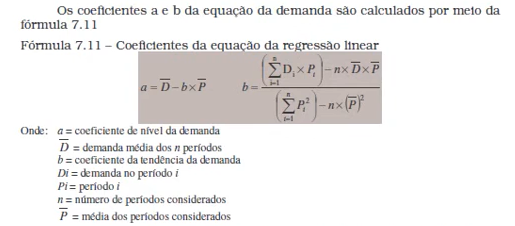
- https://www.youtube.com/watch?v=iClsHMhGxzA&t=705s
- http://www.paulorodrigues.pro.br/arquivos/livro2folhas.pdf

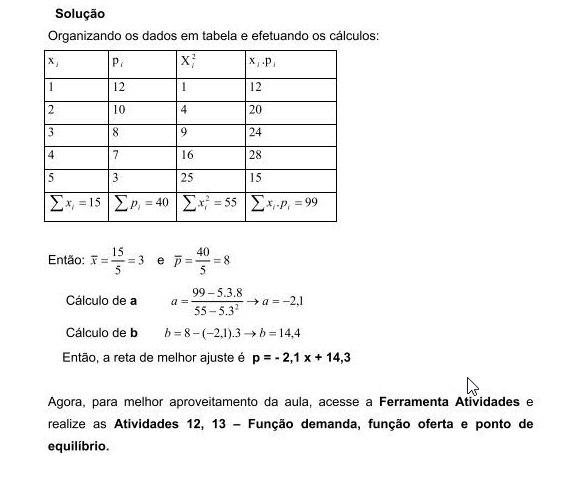
- https://www.yumpu.com/pt/document/read/14510215/aula-09-143-funcao-demanda-funcao-oferta-e-arquivos-unama

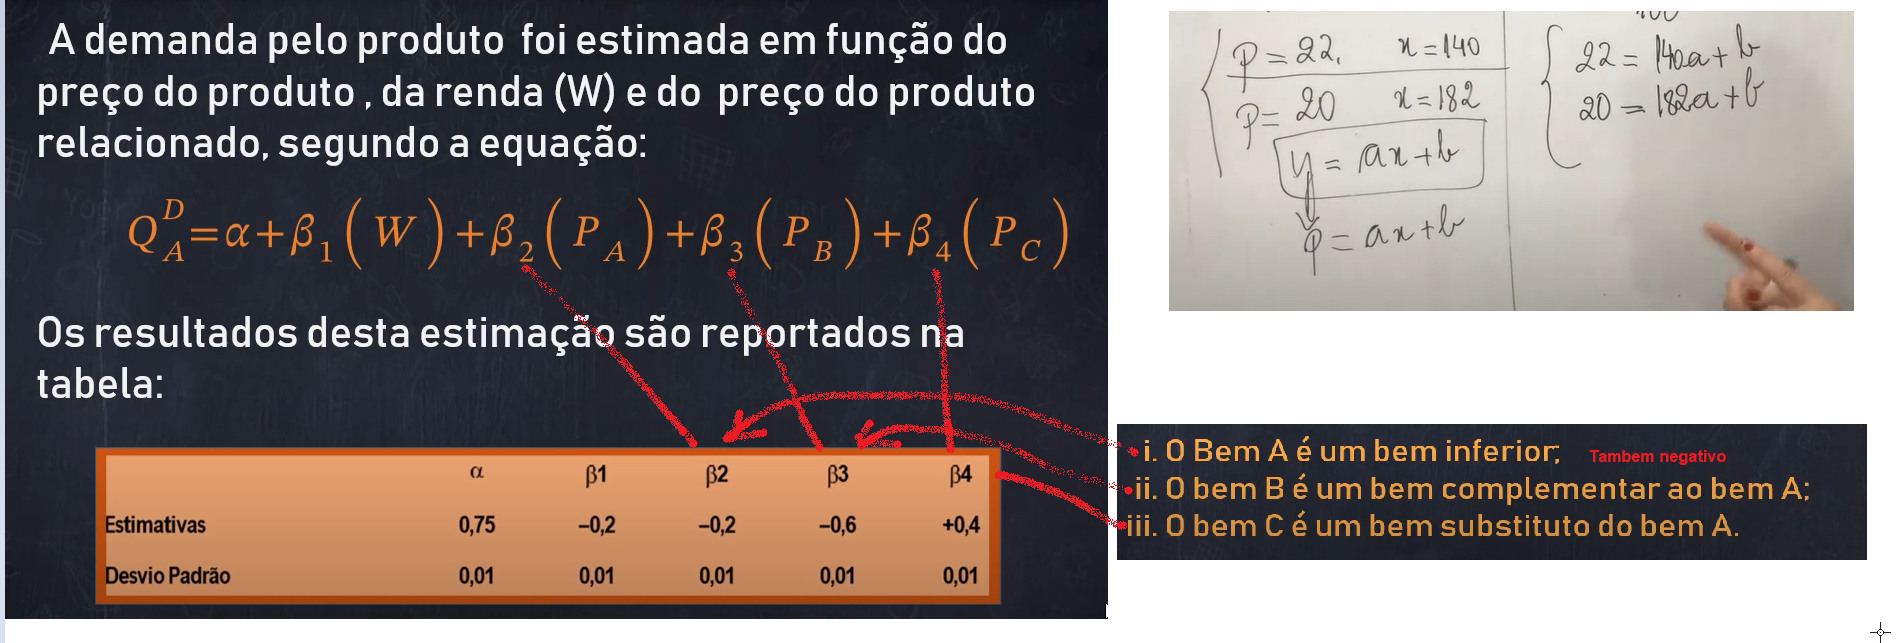

## MATOU 
- REGRESSAO IV (Instrumental Variable)
- https://www.quora.com/How-do-you-compute-a-linear-regression-line-for-a-demand-curve-using-the-square-method
- https://www.youtube.com/watch?v=p8yPGpEfCXs

# Preco Soja

In [66]:
df_soja = sl.soybean.get_all_prices()
print(df_soja.shape)
df_soja.tail()

(5270, 9)


,sb_oil_future_price,sb_oil_future_volume,sb_oil_spot_price,sb_oil_spot_volume,sb_grain_future_price,sb_grain_future_volume,sb_grain_spot_price,sb_grain_spot_volume,date
Date,,,,,,,,,
2022-03-28,1597.25,37278,1597.25,32982.0,611.51,76627.0,611.51,67994.0,2022-03-28
2022-03-29,1579.83,43690,1579.83,39382.0,603.70,107185.0,603.70,95367.0,2022-03-29
2022-03-30,1592.18,35512,1592.18,32779.0,611.42,67718.0,611.42,58228.0,2022-03-30
2022-03-31,1541.91,45771,1541.91,40143.0,594.60,96368.0,594.60,84829.0,2022-03-31
2022-04-01,1569.69,45771,1569.69,42675.0,581.56,96368.0,581.56,90031.0,2022-04-01


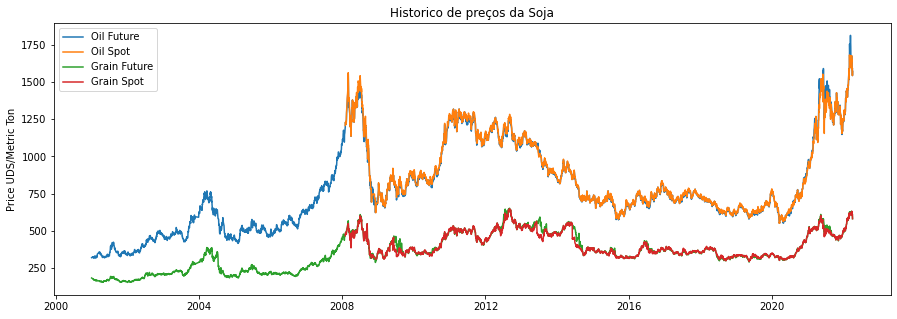

In [67]:
plt.figure(figsize=(15,5))

plt.plot(df_soja.index, df_soja['sb_oil_future_price'], label='Oil Future', );
plt.plot(df_soja.index, df_soja['sb_oil_spot_price'], label='Oil Spot');
plt.plot(df_soja.index, df_soja['sb_grain_future_price'], label='Grain Future');
plt.plot(df_soja.index, df_soja['sb_grain_spot_price'], label='Grain Spot');
# plt.plot(df_soja.index, df_soja['sb_meal_future_price'], label='Meal Future');
# plt.plot(df_soja.index, df_soja['sb_meal_spot_price'], label='Grain Spot');
plt.title("Historico de preços da Soja")
plt.ylabel('Price UDS/Metric Ton')
plt.legend(loc='best');

In [68]:
df_soja.tail()

,sb_oil_future_price,sb_oil_future_volume,sb_oil_spot_price,sb_oil_spot_volume,sb_grain_future_price,sb_grain_future_volume,sb_grain_spot_price,sb_grain_spot_volume,date
Date,,,,,,,,,
2022-03-28,1597.25,37278,1597.25,32982.0,611.51,76627.0,611.51,67994.0,2022-03-28
2022-03-29,1579.83,43690,1579.83,39382.0,603.70,107185.0,603.70,95367.0,2022-03-29
2022-03-30,1592.18,35512,1592.18,32779.0,611.42,67718.0,611.42,58228.0,2022-03-30
2022-03-31,1541.91,45771,1541.91,40143.0,594.60,96368.0,594.60,84829.0,2022-03-31
2022-04-01,1569.69,45771,1569.69,42675.0,581.56,96368.0,581.56,90031.0,2022-04-01


In [74]:
if df_soja is not None:
    df = df_soja[df_soja['sb_oil_future_price'].notnull()].copy()
    print(df.shape, df_soja.shape)
    df = df.groupby([df.index.year, df.index.month]).tail(1) 

(5270, 9) (5270, 9)


In [76]:
df.groupby([df.index.year, df.index.month]).count()

sb_oil_future_price  sb_oil_future_volume  sb_oil_spot_price  \
Date Date                                                                 
2001 1                       1                     1                  0   
     2                       1                     1                  0   
     3                       1                     1                  0   
     4                       1                     1                  0   
     5                       1                     1                  0   
...                        ...                   ...                ...   
2021 12                      1                     1                  1   
2022 1                       1                     1                  1   
     2                       1                     1                  1   
     3                       1                     1                  1   
     4                       1                     1                  1   

           sb_oil_spot_volume  sb_grain_future_price  sb_grain_future_volume  \
Date Date                                                                      
2001 1                      0                      1                       1   
     2                      0                      1                       1   
     3                      0                      1                       1   
     4                      0                      1                       1   
     5                      0                      1                       1   
...                       ...                    ...                     ...   
2021 12                     1                      1                       1   
2022 1                      1                      1                       1   
     2                      1                      1                       1   
     3                      1                      1                       1   
     4                      1                      1                       1   

           sb_grain_spot_price  sb_grain_spot_volume  date  
Date Date                                                   
2001 1                       0                     0     1  
     2                       0                     0     1  
     3                       0                     0     1  
     4                       0                     0     1  
     5                       0                     0     1  
...                        ...                   ...   ...  
2021 12                      1                     1     1  
2022 1                       1                     1     1  
     2                       1                     1     1  
     3                       1                     1     1  
     4                       1                     1     1  

[256 rows x 9 columns]

In [73]:
for i, row in df_soja.iterrows()
    

df.groupby([df.index.year, df.index.month]).tail(1) 

,sb_oil_future_price,sb_oil_future_volume,sb_oil_spot_price,sb_oil_spot_volume,sb_grain_future_price,sb_grain_future_volume,sb_grain_spot_price,sb_grain_spot_volume,date
Date,,,,,,,,,
2001-01-31,320.33,5,NaN,NaN,168.93,119.0,NaN,NaN,2001-01-31
2001-02-28,327.83,20,NaN,NaN,167.09,20.0,NaN,NaN,2001-02-28
2001-03-29,354.94,13,NaN,NaN,162.22,396.0,NaN,NaN,2001-03-29
2001-04-30,322.10,2,NaN,NaN,155.06,25.0,NaN,NaN,2001-04-30
2001-05-31,327.83,23,NaN,NaN,160.94,446.0,NaN,NaN,2001-05-31
...,...,...,...,...,...,...,...,...,...
2021-12-31,1241.20,1065,1246.27,23834.0,488.23,2572.0,492.09,55569.0,2021-12-31
2022-01-31,1429.04,48491,1429.04,45576.0,547.66,148673.0,547.66,102394.0,2022-01-31
2022-02-28,1606.95,3960,1598.79,70730.0,604.16,4729.0,601.40,108501.0,2022-02-28


In [56]:
df_soja.to_csv(f'{DATASET}\__preco_soja.csv')
sl.save_excel(df_soja, f'{DATASET}\__preco_soja.xlsx')

# Preço Girassol

In [34]:
with open(f'{DATASET}/ychart_sunflower_oil_price.json') as f:
    d = json.load(f)
    
df_temp = pd.DataFrame(d['chart_data'][0][0]['raw_data'], columns = ['date', 'sunflower_oil_price'])
df_temp['date'] = pd.to_datetime(df_temp['date'], unit='ms')
df_temp['date'] = df_temp['date'] + pd.DateOffset(1)  + pd.DateOffset(months=-1)
# df_temp['date'] = df_temp['date'].dt.strftime('%Y-%m-%d')
df_temp.set_index('date', inplace=True)
df_temp['sunflower_oil_price'] = df_temp['sunflower_oil_price'] * 19.6841
df_sun = df_temp



with open(f'{DATASET}/ychart_sunflower_oil_export_price.json') as f:
    d = json.load(f)
    
df_temp = pd.DataFrame(d['chart_data'][0][0]['raw_data'], columns = ['date', 'sunflower_oil_export_price'])
df_temp['date'] = pd.to_datetime(df_temp['date'], unit='ms')
df_temp['date'] = df_temp['date'] + pd.DateOffset(1)  + pd.DateOffset(months=-1)
df_temp.set_index('date', inplace=True)
df_sun = pd.merge(df_sun, df_temp, how="outer", left_index=True, right_index=True)



# https://www.insee.fr/en/statistiques/serie/010753754#Telechargement
df_temp = pd.read_excel(f'{DATASET}/insee_sunflower_price.xlsx', sheet_name='monthly_values', header=3)
df_temp.columns = ['date', 'insee_price']
df_temp['date'] = pd.to_datetime(df_temp['date'])
df_temp.set_index('date', inplace=True)
df_sun = pd.merge(df_sun, df_temp, how="outer", left_index=True, right_index=True)



#https://fred.stlouisfed.org/series/PSUNOUSDM
from fredapi import Fred
fred = Fred(api_key='34226d58c6bcee68e056cb4c42b8f401')
df_temp = fred.get_series('PSUNOUSDM').to_frame()
df_temp.columns = ['fred_price']
df_sun = pd.merge(df_sun, df_temp, how="outer", left_index=True, right_index=True)




E:\Projetos\ITA_Tese\.env-win-tese\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [35]:
req = requests.get('https://www.sunflowernsa.com/growers/Marketing/daily-oilseed-sunflower-price/')
soup = BeautifulSoup(req.text)
tb = soup.find_all('table')[1]
tb = soup.find_all('table')[1]
df_temp = pd.read_html(str(tb))[0]
df_temp = df_temp.dropna(axis=1, how='all')
df_temp = df_temp.iloc[3:-3, :].copy()
df_temp = df_temp.dropna(axis=0, how='all')
df_temp = df_temp.replace(regex=[r'\$'], value='')
df_temp = df_temp.dropna(axis=1, how='all')
df_temp.columns = ['date', 'tipo1', 'tipo2', 'tipo3']
df_temp['date'] = pd.to_datetime(df_temp['date'], format='%m/%d/%Y')
df_temp.set_index('date', inplace=True)
df_temp = df_temp.astype(float)
df_temp.dtypes
df_temp['average'] = round(df_temp.mean(axis=1),2)
df_temp['price'] = df_temp['average'] * 19.6841

df_temp = df_temp[['price']]
df_temp = df_temp[df_temp.index > pd.to_datetime(THIS_YEAR, format=DATE_FORMAT)]

df_sun = pd.merge(df_sun, df_temp, how="outer", left_index=True, right_index=True)

In [36]:
# df_sun = df_sun[df_sun.index > pd.to_datetime(MIN_DATE, format=DATE_FORMAT)]
# df_sun


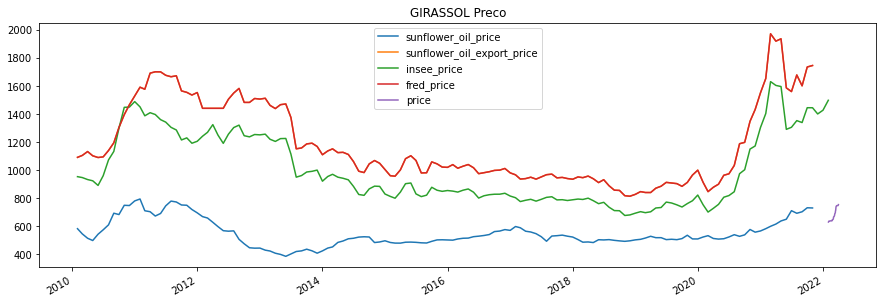

In [37]:
fig, axs = plt.subplots(figsize=(15,5))
df_sun[df_sun.index > pd.to_datetime(MIN_DATE, format=DATE_FORMAT)].plot(ax = axs);
plt.title(f'GIRASSOL Preco');

In [38]:
df_sun['date'] = df_sun.index
df_sun.to_csv(f'{DATASET}\__preco_girassol.csv')
sl.save_excel(df_sun, f'{DATASET}\__preco_girassol.xlsx' )

In [79]:
df_sun.iloc[-50:-30,:]

,sunflower_oil_price,sunflower_oil_export_price,insee_price,fred_price,price,date
2021-04-01,615.915489,1919.70,1604.2,1919.695833,NaN,2021-04-01
2021-05-01,638.158522,1936.49,1596.2,1936.486706,NaN,2021-05-01
2021-06-01,650.559505,1586.46,1291.1,1586.464583,NaN,2021-06-01
2021-07-01,711.383374,1560.26,1305.7,1560.264583,NaN,2021-07-01
2021-08-01,692.880320,1678.71,1353.2,1678.710417,NaN,2021-08-01
2021-09-01,703.509734,1601.20,1339.5,1601.202083,NaN,2021-09-01
2021-10-01,732.051679,1735.49,1445.2,1735.490079,NaN,2021-10-01
2021-11-01,730.673792,1746.12,1445.0,1746.120833,NaN,2021-11-01
2021-12-01,NaN,NaN,1400.8,NaN,NaN,2021-12-01
2022-01-01,NaN,NaN,1427.4,NaN,NaN,2022-01-01


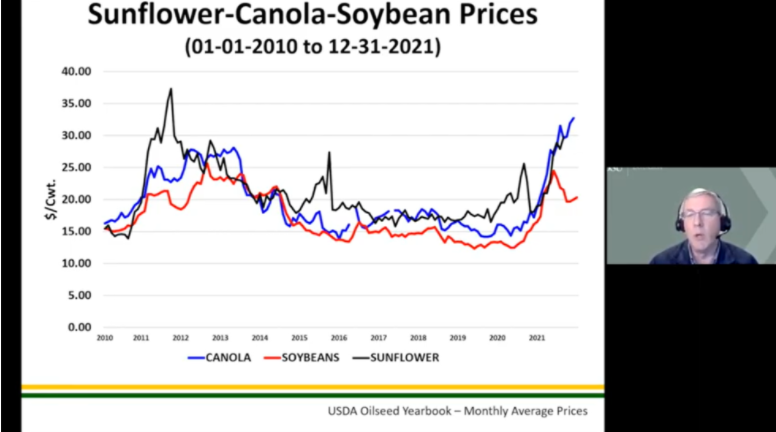

In [13]:
df_vol = df_soja[['sb_oil_spot_price', 'sb_oil_spot_volume']]
df_vol
df_vol

,sb_oil_spot_price,sb_oil_spot_volume
Date,,
2010-01-04,910.29,51055.0
2010-01-05,906.10,26802.0
2010-01-06,905.44,35365.0
2010-01-07,889.79,147.0
2010-01-08,879.87,35634.0
...,...,...
2022-03-23,1674.85,31251.0
2022-03-24,1637.81,35571.0
2022-03-25,1647.96,31999.0
